# Hierarchical product categorisation based on text descriptions

In [1]:
# Import libraries

# Data wrangling tools
import pandas as pd

# Text-processing tools
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Model creation, saving and evaluation tools
from sklearn.model_selection import train_test_split, StratifiedKFold, \
                                    cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB   
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt

### EDA

In [2]:
prod_cat_df = pd.read_csv('product-category-dataset.csv')
print(prod_cat_df.shape)
prod_cat_df.info()

(10639, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10639 entries, 0 to 10638
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  10627 non-null  object
 1   Level_1      10639 non-null  object
 2   Level_2      10639 non-null  object
 3   Level_3      10639 non-null  object
dtypes: object(4)
memory usage: 332.6+ KB


Based on this initial investigation, we have data consisting of 10,649 rows and 4 columns. The columns are named 'Description', 'Level_1', 'Level_2' and 'Level_3'. 'Description' contains text-based descriptions but has many truncated words so it is a bit tricky to parse. It also has 12 missing values, as we can see from the information returned from the `.info()` command. The level-1, -2 and -3 categories contain strings of integers/letters, which are harder to interpret, but presumably categorise the data. There are fewer level-1 classes than level-2 and level-3. It seems that level 2 and 3 are subcategories of level 1. 

In [3]:
# Drop description column for plotting
just_levels_df = prod_cat_df.drop('Description', axis=1).copy()

# Group by level and count each category
plotting_df_1 = pd.DataFrame()
plotting_df_1['L1_Counts'] = just_levels_df['Level_1'].value_counts().copy()
plotting_df_1 = plotting_df_1.reset_index(level=0) \
                         .rename(columns={'index': 'Level_1'}).copy()
plotting_df_2 = pd.DataFrame()
plotting_df_2['L2_Counts'] = just_levels_df['Level_2'].value_counts().copy()
plotting_df_2 = plotting_df_2.reset_index(level=0) \
                         .rename(columns={'index': 'Level_2'}).copy()
plotting_df_3 = pd.DataFrame()
plotting_df_3['L3_Counts'] = just_levels_df['Level_3'].value_counts().copy()
plotting_df_3 = plotting_df_3.reset_index(level=0) \
                         .rename(columns={'index': 'Level_3'}).copy()

# Create new df for plotting with categories and counts
final_plotting_df = pd.merge(plotting_df_3.copy(), just_levels_df, \
                             on='Level_3').drop_duplicates()
final_plotting_df = pd.merge(final_plotting_df, plotting_df_2, \
                             on='Level_2')
final_plotting_df = pd.merge(final_plotting_df, plotting_df_1, \
                             on='Level_1')

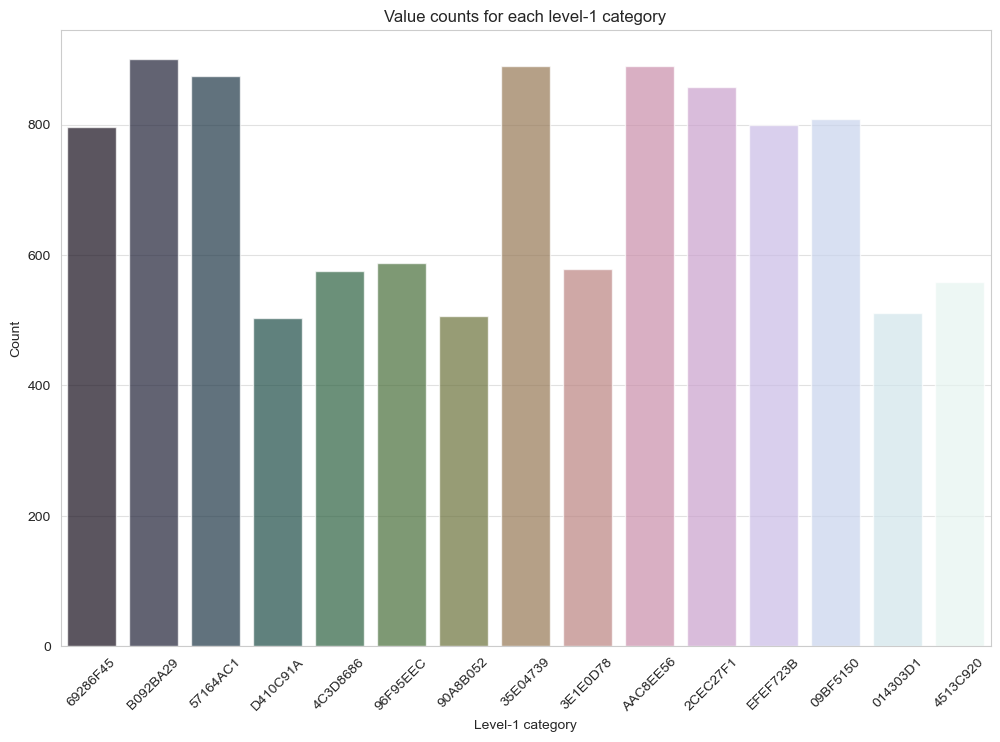

In [4]:
# Set grid style for plots
sns.set_style("whitegrid", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.color': 'e1e1e1'
 })

fig,ax = plt.subplots(figsize=(12,8))
barplt_l1 = sns.barplot(x='Level_1', y='L1_Counts',data=final_plotting_df, \
                        palette='cubehelix', alpha=0.7)
barplt_l1.set_title('Value counts for each level-1 category')
barplt_l1.set_xlabel('Level-1 category')
barplt_l1.set_ylabel('Count')
barplt_l1.set_xticklabels(barplt_l1.get_xticklabels(), rotation=45)

plt.show()

True


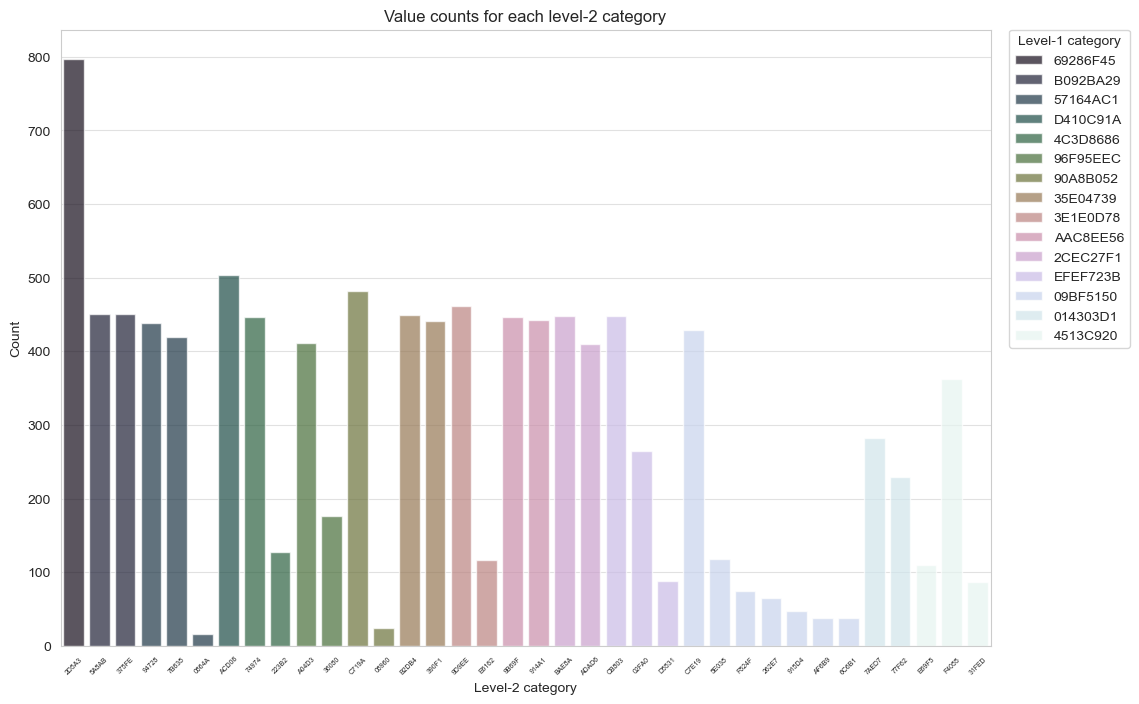

In [5]:
fig,ax = plt.subplots(figsize=(12, 8))
barplt_l2 = sns.barplot(x='Level_2', y='L2_Counts',data=final_plotting_df, \
                        palette='cubehelix', alpha=0.7, hue='Level_1', dodge=False)
barplt_l2.set_title('Value counts for each level-2 category')
barplt_l2.set_xlabel('Level-2 category')
barplt_l2.set_ylabel('Count')
barplt_l2.set_xticklabels(barplt_l2.get_xticklabels(), rotation=45, size=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', \
           borderaxespad=0, title='Level-1 category')
# Check that none of the level-2 categories appear in muliple level-1 categories
print(len(barplt_l2.get_xticklabels())==final_plotting_df['Level_2'].nunique())
plt.show()

True


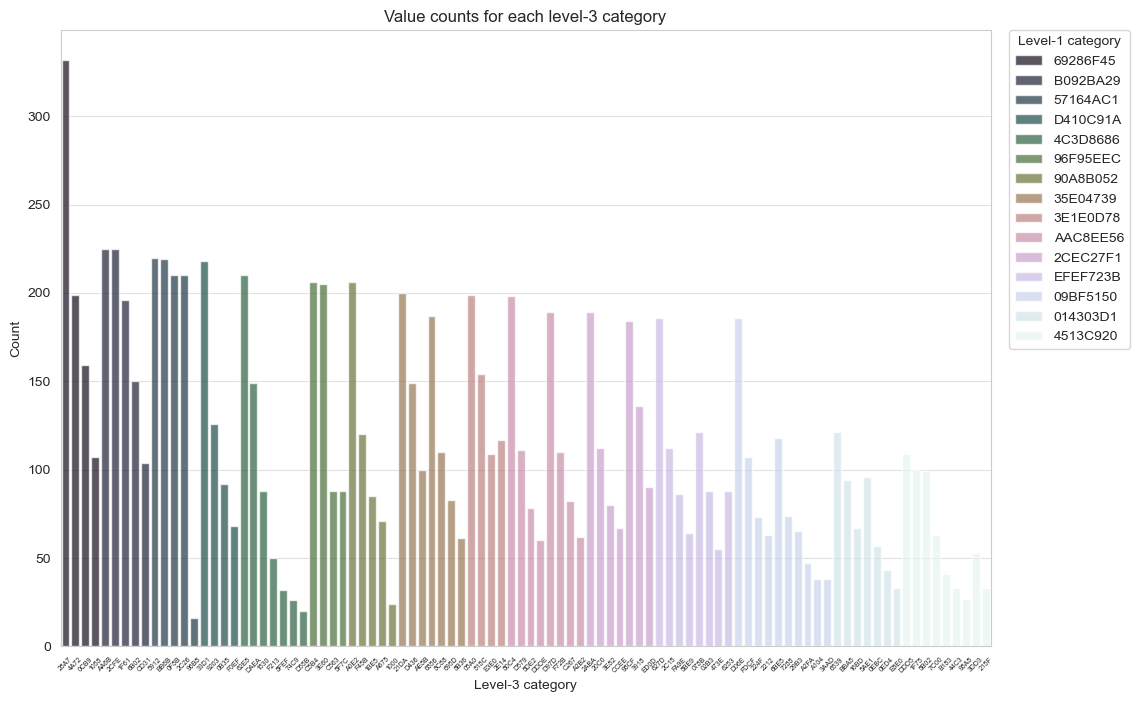

In [6]:
fig,ax = plt.subplots(figsize=(12, 8))
barplt_l3 = sns.barplot(x='Level_3', y='L3_Counts',data=final_plotting_df, \
                        palette='cubehelix', alpha=0.7, hue='Level_1', dodge=False)
barplt_l3.set_title('Value counts for each level-3 category')
barplt_l3.set_xlabel('Level-3 category')
barplt_l3.set_ylabel('Count')
barplt_l3.set_xticklabels(barplt_l3.get_xticklabels(), rotation=45, size=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', \
           borderaxespad=0, title='Level-1 category')
# Check that none of the level-3 categories appear in muliple level-1 categories
print(len(barplt_l3.get_xticklabels())==final_plotting_df['Level_3'].nunique())
plt.show()

These visualisations emphasise that the data is not balanced, with the starkest difference in level 2, where the most frequently occuring category ('2D5A3', count: 797) occurs nearly 50 times more than the least frequently occuring category ('0864A', count: 16).

### Deal with Missing Data

In [7]:
# Check if data has missing values in the Description column
null_data = prod_cat_df[prod_cat_df.isnull().any(axis=1)] #get the null data
print(null_data, '\n' , null_data.count()) #there are 12 missing values

     Description   Level_1 Level_2 Level_3
1063         NaN  4C3D8686   74974    62E8
3434         NaN  09BF5150   F824F    7288
3458         NaN  09BF5150   F824F    7288
7754         NaN  09BF5150   6C6B1    3AAD
7788         NaN  09BF5150   6C6B1    3AAD
7796         NaN  09BF5150   5E038    6BE5
7808         NaN  09BF5150   5E038    6BE5
7859         NaN  09BF5150   5E038    6BE5
7936         NaN  09BF5150   262E7    29B3
7962         NaN  09BF5150   262E7    29B3
7988         NaN  09BF5150   AF6B9    A104
8004         NaN  09BF5150   AF6B9    A104 
 Description     0
Level_1        12
Level_2        12
Level_3        12
dtype: int64


The null data is mostly in the Level-1 category 09BF5150, with 11 out of 12 items falling into this category. Three of these values are in the same Level-2 and -3 categories, 5E038 and 6BE5 repectively. 

There are 810 rows in the Level-1 category '09BF5150'. This is possibly mostly kids' clothing and technology based on a cursory look at 'Description'. The missing values make up just over 1% of the data in this category.

There are 118 rows in these Level-2 and -3 categories, and they completely overlap. Many of the rows that fall into these categories seem likely to be mobile phones based on a quick look at 'Description'. The missing values make up just over 2.5% of the data in these categories.

The total of 12 missing values is quite low overall, and the 11 missing values which fall into the same Level_1 category (09BF5150) only make up just over 1% of the data in this category. Of these, the 3 missing values which also fall into the same Level_2 and 3 categories (5E038 and 6BE5 respectively) make up just over 2.5% of the data in these categories. The proportions of missing data are low enough that the rows with missing 'Description' data can be safely discarded. We can also drop any categorie for which therer are fewer than ten instances.

In [8]:
# Deal with missing values by dropping them
prod_cat_df_clean = prod_cat_df.dropna().copy()

# Drop classes with fewer than 10 instances
prod_cat_df_clean = prod_cat_df_clean[(prod_cat_df_clean.groupby('Level_1').Level_1.transform('count')>=10) &
                                      (prod_cat_df_clean.groupby('Level_2').Level_2.transform('count')>=10) &
                                      (prod_cat_df_clean.groupby('Level_3').Level_3.transform('count')>=10)]
prod_cat_df_clean

,Description,Level_1,Level_2,Level_3
0,gerb cap help keep littl on head cov warm day ...,09BF5150,C7E19,FDCF
1,newborn inf toddl boy hoody jacket oshkosh b g...,2CEC27F1,ADAD6,ED0D
2,tut ballet anym leap foxy fash ruffl tul toddl...,09BF5150,C7E19,D06E
3,newborn inf toddl boy hoody jacket oshkosh b g...,2CEC27F1,ADAD6,98CF
4,easy keep feel warm cozy inf toddl girl hoody ...,2CEC27F1,ADAD6,3918
...,...,...,...,...
10634,term 10 issu on year subscriptionyo sav 75 cov...,90A8B052,C719A,1BE5
10635,term 12 issu on year subscriptionyo sav 86 cov...,90A8B052,C719A,F45B
10636,term 9 issu on year subscriptionyo sav 64 cov ...,90A8B052,C719A,A0E2
10637,term 26 issu on year subscriptionyo sav 54 cov...,90A8B052,C719A,1BE5


## Text processing and TF-IDF vectorisation

In [9]:
text = 'Test, sentence 99 One two three!'

word_tokens = word_tokenize(text)
lower_case_text = [word.lower() for word in word_tokens]
words_only = [x for x in lower_case_text if x not in string.punctuation]
words_only

['test', 'sentence', '99', 'one', 'two', 'three']

In [10]:
# Define text-processing function
def process_text(text):
    """
    Processes raw text data.

    Parameters
    ----------
    text : string
                String of raw text to be processed.

    Returns
    -------
    precessed_words : String
                Processed text in string form
    """   
    # Tokenise into words
    word_tokens = word_tokenize(text)
    
    # Convert text to lower case 
    lower_case_text = [w.lower() for w in word_tokens]
    # Remove punctuation
    no_punc = [w for w in lower_case_text if w not in string.punctuation]
    # Instantiate stemmer
    ps = PorterStemmer()
    # Apply stemming
    stemmed_words = [ps.stem(w) for w in no_punc]
    # Rejoin tokens, separated by whitespace, into a string 
    stemmed_words_string = ' '.join(stemmed_words)
    
    # Return the tokenised text as a string
    return stemmed_words_string

In [11]:
# Add processed text as a new column in dataframe
prod_cat_df_clean['processed_description'] = \
                [process_text(text) for text in \
                          prod_cat_df_clean['Description'].tolist()]

In [12]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5))

tfidf_matrix = tfidf_vectorizer \
                    .fit_transform(prod_cat_df_clean['processed_description'])

## Classification

**There are 15 'Level 1' classes, 36 'Level 2' classes and 94 'Level 3' classes.**

- The 'round 1' classifier will need to be a single multiclass classifier which splits the data into 15 classes corresponding to their level-1 classification.

- Then, 15 separate multiclass-classifier models are needed to separate the the already-classified level-1 items into level-2 subgroups.

- Each level-3 category is a subgroup of a level-2 category, and each level-2 category is a subcategory of a level-1 category; EDA confirms that there are no level-2 or -3 classes which straddle parent categories. 

- There are 36 level-1/level-2 combinations. 36 separate multiclass-classifier models are needed to separate the the already-classified level-2 items into level-3 subgroups.

### Train-test split

In [13]:
X, y = tfidf_matrix, \
       prod_cat_df_clean[['Level_1', 'Level_2', 'Level_3']].copy()

In [14]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size=0.2, \
                                                    random_state=42, \
                                                    stratify=y)

print(X_train.shape, '\n', X_test.shape, '\n', y_train.shape, '\n', y_test.shape)

(8501, 900670) 
 (2126, 900670) 
 (8501, 3) 
 (2126, 3)


Now the data is split into 80% training data and 20% test data. The input for the classifier is the TF-IDF sparse matrix, and the target outputs are the Level 1, 2 and 3 classifications.

In [15]:
# Assign variables to the train/test predictor variables for each level
class1 = y_train['Level_1']
class2 = y_train['Level_2']
class3 = y_train['Level_3']

class1_test = y_test['Level_1']
class2_test = y_test['Level_2']
class3_test = y_test['Level_3']

The [SK-Learn documentation](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) suggests that the multinomial variant of the Naïve Bayes classifier is a good starting point for the task of text classification. [Wang](https://www.toptal.com/machine-learning/nlp-tutorial-text-classification) also mentions the use of Naïve Bayes in the context of spam detection, and notes that support vector machines are sometimes used for text classification, for example in a medical context. I will try various options and will use the classifier that gives the best results on the training set based on cross-validation.

### Model selection

In [17]:
# Split the training data into 5 folds, stratified based on classes
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Test different classifiers
test_classifiers = [MultinomialNB(), \
                    ComplementNB(), \
                    KNeighborsClassifier(), \
                    SVC()]

levels = [class1, class2, class3]

for classifier in test_classifiers:
    clf = classifier
    print(classifier)
    for i,level in enumerate(levels): 
        clf.fit(X_train, level)
        print('Level {}'.format(i+1))
        print(cross_val_score(clf, X_train, level, cv=k_fold, n_jobs=1))
    print('---')

MultinomialNB()
Level 1
[0.84244562 0.82647059 0.85058824 0.84705882 0.84588235]
Level 2
[0.6255144  0.64176471 0.65705882 0.62470588 0.64058824]
Level 3
[0.23633157 0.23352941 0.23823529 0.23176471 0.22058824]
---
ComplementNB()
Level 1
[0.89182834 0.88529412 0.89470588 0.90470588 0.90352941]
Level 2
[0.80129336 0.81058824 0.81352941 0.80882353 0.80764706]
Level 3
[0.37154615 0.35588235 0.36294118 0.35764706 0.34823529]
---
KNeighborsClassifier()
Level 1
[0.83068783 0.83176471 0.83470588 0.83411765 0.83529412]
Level 2
[0.71252205 0.71941176 0.71941176 0.72117647 0.74058824]
Level 3
[0.28747795 0.27882353 0.30705882 0.28352941 0.28117647]
---
SVC()
Level 1
[0.81716637 0.82       0.83058824 0.83117647 0.83117647]
Level 2
[0.73486185 0.73705882 0.74058824 0.75352941 0.73235294]
Level 3
[0.27572016 0.28       0.27235294 0.26470588 0.25294118]
---


The **Complement Naïve Bayes Classifier** seems to perform the best, even with its default hyperparameters. For each of the classifiers, the accuracy on the validation set drops off from level 1 to 3, but since the categories are nested, if we nest our models similarly, this might improve the results.

There are not many hyperparameters,but I will try tweaking the ones that exist to see whether performance can be improved further. 

### Optimise Parameters using Cross Validation and GridSearch()

In [18]:
# Parameter grid for grid search cross-validation
param_grid = {
    'alpha': [0.01, 0.2, 0.5, 0.8, 1.0],
    'fit_prior': [True, False],
    'class_prior': [None],
    'norm': [True, False]
}

optimal_params = GridSearchCV(
    estimator=ComplementNB(),
        param_grid=param_grid,
        scoring='roc_auc',
        verbose=0,
        n_jobs=10,
        cv=5
    )

optimal_params.fit(X_train, class1)
model_1_params = optimal_params.best_params_
print('Model 1 parameters:\n{}'.format(model_1_params))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Model 1 parameters:
{'alpha': 0.01, 'class_prior': None, 'fit_prior': True, 'norm': True}


In this instance we can get away with having alpha set very low because we used the whole corpus to generate the bag of n-grams tokens, and we are confident that the classifier will not encounter anything that isn't in the bag of tokens (i.e. everything we are going to be using to classify the items is in the TF-IDF matrix). In a real-world scenario we would expect that the classifier might, at some point, come across something that is not in the bag of tokens. If this were to happen, having alpha set to a higher value would help to mitigate the issues caused by this, which is why 1.0 is the default value. [ref1](https://stats.stackexchange.com/questions/108797/in-naive-bayes-why-bother-with-laplace-smoothing-when-we-have-unknown-words-in), [ref2](https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece).

I will use this model and these hyperparameters for the classification models for each of the levels.

### Model training

In [19]:
# Define chosen model
model = ComplementNB(alpha=0.01, class_prior=None, \
                             fit_prior=True, norm=True)

# Fit for level-1 classification 
level_1_model = model.fit(X_train, class1)
# Save the model to disk
filepath = 'models/level_1_model.pk'
pickle.dump(level_1_model, open(filepath, 'wb'))

In [20]:
# Loop through the level-1 categories and train 
# a separate level-2 model for each level-1 category in the training set
for i,l1_class in enumerate(prod_cat_df_clean.Level_1.unique()): 
    # These are the indices to retain in the sparse matrix 
    # of training data for each iteration of this loop
    L1_class_indices_list = [j for j,c in enumerate(class1) 
                             if c==l1_class]
    # Get the predictive data for the items in each level-1 class 
    # of the training set
    X_train_2 = X_train[L1_class_indices_list]
    # Get the level-2 classes for the items in each level-1 class 
    # of the training set
    y_train_2 = class2.iloc[L1_class_indices_list]
    model = model.fit(X_train_2, y_train_2)
    # Pickle it
    filepath = 'models/level_2_model_{}.pk'.format(i+1)
    pickle.dump(model, open(filepath, 'wb'))

In [21]:
# Loop through the level-2 categories and train 
# a separate level-3 model for each level-3 category in the training set
for i,l2_class in enumerate(prod_cat_df_clean.Level_2.unique()): 
    # These are the indices to retain in the sparse matrix 
    # of training data for each iteration of this loop
    L2_class_indices_list = [j for j,c in enumerate(class2) 
                             if c==l2_class]
    # Get the predictive data for the items in each level-1 class 
    # of the training set
    X_train_3 = X_train[L2_class_indices_list]
    # Get the level-2 classes for the items in each level-1 class 
    # of the training set
    y_train_3 = class3.iloc[L2_class_indices_list]
    model = model.fit(X_train_3, y_train_3)
    # Pickle it
    filepath = 'models/level_3_model_{}.pk'.format(i+1)
    pickle.dump(model, open(filepath, 'wb'))

## Predict the test set

In [22]:
# Create an empty Dataframe with column names only
results = pd.DataFrame(columns=['Level1_Pred', 'Level2_Pred', 'Level3_Pred'])

# Reload the saved models and use them to predict the levels
# Load model for level 1

# .pk file extension is for a pickled file; 
# 'rb' mode reads the file in binary format
with open('models/level_1_model.pk', 'rb') as nb: 
    model = pickle.load(nb)
    predicted1 = model.predict(X_test)
    
results['Level1_Pred'] = predicted1 # Add these results to the Results df

In [23]:
# Loop through the level-1 test-set predictions and load 
# a separate level-2 model for each level-1 category
for i,l1_class in enumerate(prod_cat_df_clean.Level_1.unique()): 
    # These are the indices to retain in the sparse matrix 
    # of test data for each iteration of this loop
    L1_class_indices_list = [j for j,c in enumerate(class1_test) 
                             if c==l1_class]
    # Get the predictive data for the items in each level-1 class 
    # of the training set
    X_test_2 = X_test[L1_class_indices_list]
    # Get the level-2 classes for the items in each level-1 class 
    # of the training set
    y_test_2 = class2_test.iloc[L1_class_indices_list]
    
    with open('models/level_2_model_{}.pk'.format(i+1), 'rb') as nb: 
        model = pickle.load(nb)
        L2_prediction = model.predict(X_test_2)
        results.at[L1_class_indices_list, 'Level2_Pred'] = L2_prediction

In [24]:
# Loop through the level-2 test-set predictions and load 
# a separate level-3 model for each level-1 category
for i,l2_class in enumerate(prod_cat_df_clean.Level_2.unique()): 
    # These are the indices to retain in the sparse matrix 
    # of test data for each iteration of this loop
    L2_class_indices_list = [j for j,c in enumerate(class2_test) 
                             if c==l2_class]
    # Get the predictive data for the items in each level-1 class 
    # of the training set
    X_test_3 = X_test[L2_class_indices_list]
    # Get the level-2 classes for the items in each level-1 class 
    # of the training set
    y_test_3 = class3_test.iloc[L2_class_indices_list]
    
    with open('models/level_3_model_{}.pk'.format(i+1), 'rb') as nb: 
        model = pickle.load(nb)
        L3_prediction = model.predict(X_test_3)
        results.at[L2_class_indices_list, 'Level3_Pred'] = L3_prediction
        
results

,Level1_Pred,Level2_Pred,Level3_Pred
0,69286F45,2D5A3,28A7
1,EFEF723B,CB803,078B
2,3E1E0D78,9D9EE,818C
3,09BF5150,C7E19,D06E
4,AAC8EE56,914A1,F72B
...,...,...,...
2121,3E1E0D78,9D9EE,818C
2122,57164AC1,7B638,2C26
2123,2CEC27F1,ADAD6,98CF
2124,B092BA29,375FE,AA6B


## Compute accuracy for predictions at each level

In [25]:
# Level 1 accuracy
# Precision and recall for each category
y_true_1 = class1_test
y_pred_1 = results['Level1_Pred']

print(classification_report(y_true_1, y_pred_1, zero_division=1))

              precision    recall  f1-score   support

    014303D1       0.41      0.85      0.55       102
    09BF5150       0.95      0.50      0.66       159
    2CEC27F1       0.94      0.78      0.86       171
    35E04739       0.89      0.88      0.89       178
    3E1E0D78       0.97      0.73      0.83       116
    4513C920       0.77      0.85      0.81       113
    4C3D8686       0.91      0.92      0.92       115
    57164AC1       0.97      0.82      0.89       175
    69286F45       0.98      0.96      0.97       159
    90A8B052       0.89      0.96      0.92       101
    96F95EEC       0.88      0.96      0.91       118
    AAC8EE56       0.97      0.94      0.95       178
    B092BA29       0.97      0.87      0.91       180
    D410C91A       0.73      0.98      0.84       101
    EFEF723B       0.91      0.97      0.94       160

    accuracy                           0.86      2126
   macro avg       0.88      0.87      0.86      2126
weighted avg       0.89   

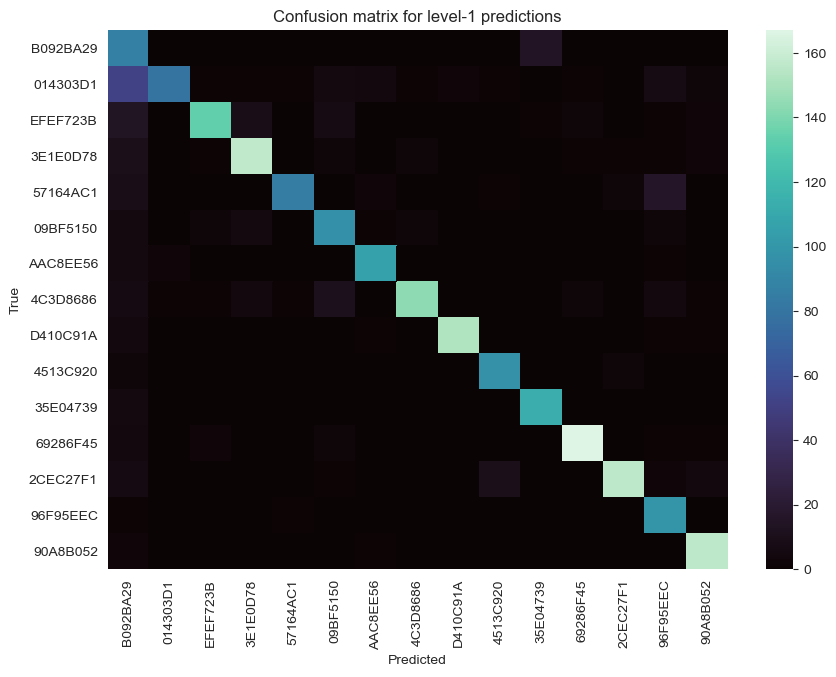

In [26]:
# By default, sklearn.metrics.confusion_matrix(y_true, y_pred) 
# creates the matrix in the order the classes appear in y_true.
# https://stackoverflow.com/questions/63649660/how-to-know-scikit-learn-confusion-matrixs-label-order-and-change-it
ticklabels_1 = set(y_true_1.tolist())

plt.figure(figsize=(10,7))
conf_1 = sns.heatmap(confusion_matrix(y_true_1, y_pred_1), \
                     xticklabels=ticklabels_1, yticklabels=ticklabels_1, \
                     cmap='mako')
conf_1.set_title('Confusion matrix for level-1 predictions')
conf_1.set_xlabel('Predicted')
conf_1.set_ylabel('True')
plt.show()

In [27]:
# Level 2 accuracy
# Precision and recall for each category
y_true_2 = class2_test
y_pred_2 = results['Level2_Pred']

print(classification_report(y_true_2, y_pred_2, zero_division=1))

              precision    recall  f1-score   support

       02FA0       0.81      0.87      0.84        53
       0864A       0.20      0.33      0.25         3
       08960       1.00      0.80      0.89         5
       223B2       0.95      0.84      0.89        25
       262E7       0.67      0.62      0.64        13
       2D5A3       1.00      1.00      1.00       159
       31FED       0.94      0.83      0.88        18
       36080       0.91      0.56      0.69        36
       375FE       0.76      0.66      0.70        90
       390F1       0.89      0.99      0.94        88
       5A8AB       0.70      0.79      0.74        90
       5E038       0.64      0.91      0.75        23
       6C6B1       0.75      0.43      0.55         7
       74974       0.96      0.99      0.97        90
       77F62       1.00      0.93      0.97        46
       7AED7       0.95      1.00      0.97        56
       7B638       0.86      0.88      0.87        84
       914A1       0.95    

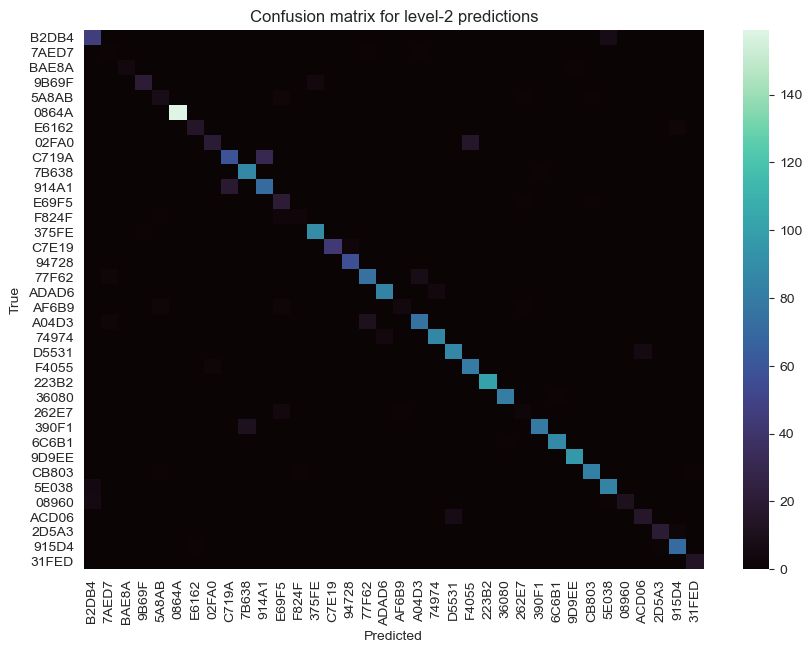

In [28]:
df_2 = pd.DataFrame(confusion_matrix(y_true_2, y_pred_2))
ticklabels_2 = set(y_true_2.tolist())

plt.figure(figsize=(10,7))
conf_2 = sns.heatmap(confusion_matrix(y_true_2, y_pred_2), \
                     xticklabels=ticklabels_2, yticklabels=ticklabels_2, \
                     cmap='mako')
conf_2.set_title('Confusion matrix for level-2 predictions')
conf_2.set_xlabel('Predicted')
conf_2.set_ylabel('True')
plt.show()

In [29]:
# Level 3 accuracy
# Precision and recall for each category
y_true_3 = class3_test
y_pred_3 = results['Level3_Pred']

print(classification_report(y_true_3, y_pred_3, zero_division=1))

              precision    recall  f1-score   support

        02B3       0.36      0.28      0.31        18
        05A0       0.49      0.47      0.48        40
        078B       0.48      0.67      0.56        24
        0B35       0.09      0.06      0.07        18
        0CB9       0.32      0.38      0.34        32
        0EBC       0.36      0.36      0.36        11
        0ED4       0.14      0.11      0.12         9
        0F8B       0.49      0.45      0.47        42
        1000       1.00      1.00      1.00         5
        1058       0.12      0.10      0.11        21
        1530       0.30      0.17      0.21        18
        16BD       0.30      0.23      0.26        13
        1BE5       0.33      0.06      0.10        17
        1F61       0.44      0.46      0.45        39
        1F75       0.36      0.40      0.38        20
        20C0       0.21      0.18      0.20        22
        215F       0.00      0.00      0.00         7
        21DA       0.47    

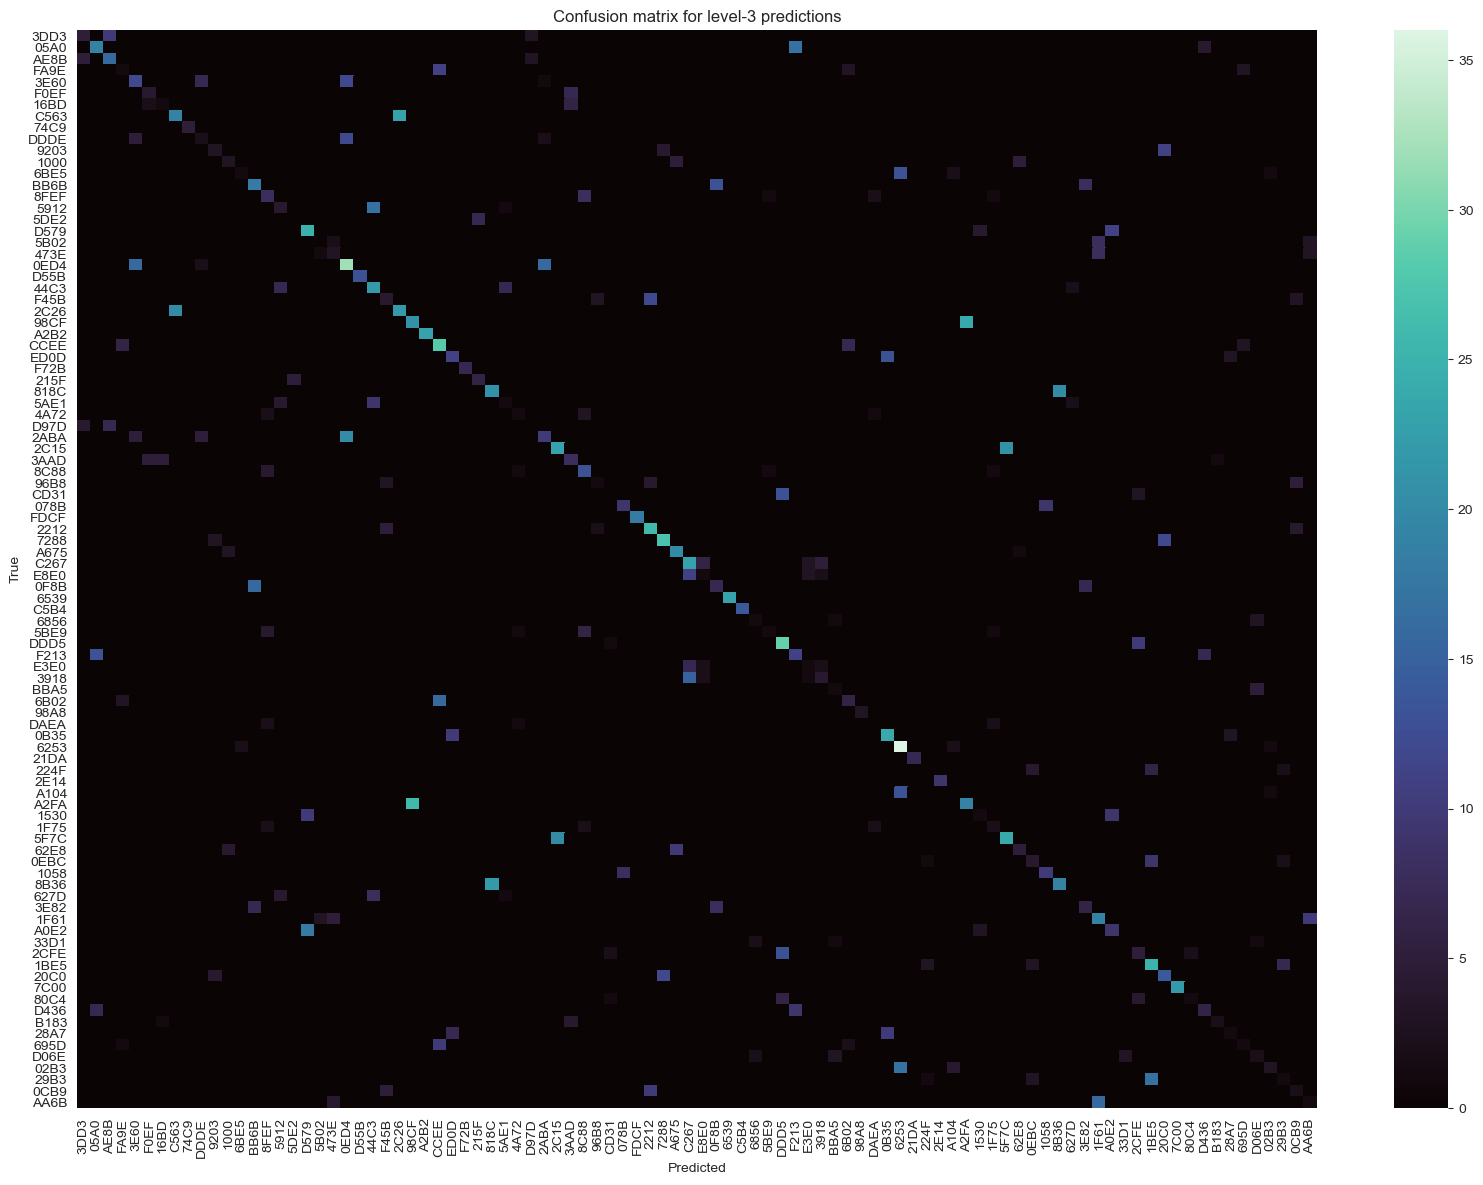

In [30]:
ticklabels_3 = set(y_true_3.tolist())

plt.figure(figsize=(20,14))
conf_3 = sns.heatmap(confusion_matrix(y_true_3, y_pred_3), \
                     xticklabels=ticklabels_3, yticklabels=ticklabels_3, \
                     cmap='mako')
conf_3.set_title('Confusion matrix for level-3 predictions')
conf_3.set_xlabel('Predicted')
conf_3.set_ylabel('True')
plt.show()